# RDD: Find discontinuities caused by a global event

## 1. Basics 

Import libraries

In [1]:
%matplotlib inline

from datetime import datetime, timedelta
import scipy.stats
import codecs                     # load UTF-8 Content
import json                       # load JSON files
import pandas as pd               # Pandas handles dataframes
import numpy as np                # Numpy handles lots of basic maths operations
import matplotlib.pyplot as plt   # Matplotlib for plotting
import seaborn as sns             # Seaborn for beautiful plots
from dateutil import *            # I prefer dateutil for parsing dates
import math                       # transformations
import statsmodels.formula.api as smf  # for doing statistical regression
import statsmodels.api as sm      # access to the wider statsmodels library, including R datasets
from collections import Counter   # Counter is useful for grouping and counting
import scipy
from patsy import dmatrices
import statsmodels.formula.api as sm
import datetime

/Users/eelcowiechert/anacona36/anaconda/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


Set global variables

In [2]:
N=7                          # the period, in days, before and after the event we are interested in
COUNTRY_OF_INTEREST = 'US'     # for which country we want to do the data analysis


Set global functions

In [3]:
def read_events(a_file):
    events = pd.read_csv(a_file, sep=",", names=['id', 'description', 'year', 'month', 'day', 'category'])
    return events

## 2. Load event data

We load the events in a Pandas dataframe and create a new column that contains the date in one cell. The date is converted to datetime in order to make future processing easier. As we only have music data up till 2015, we filter out all the events after 01/01/2015.


---------------------------------------------------------

Preview of the dataset

    id        description  year  month  day category       date
60  60           iPhone 6  2014      9    9     tech 2014-09-09
61  61  Samsung Galaxy S5  2014      2   25     tech 2014-02-25
62  62            Nexus 6  2014     10   16     tech 2014-10-16
63  63             Moto G  2014     11   28     tech 2014-11-28
64  64     Samsung Note 4  2014      8   31     tech 2014-08-31

---------------------------------------------------------

Total number of events: 168

---------------------------------------------------------

Visual overview of events



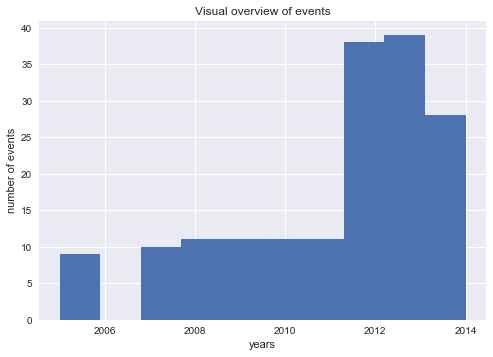

In [4]:
events = read_events("../data/events.csv")

# The dataset has the year, month, and day in three different cells. We would like to have this information in one cell
dates = []
for index, row in events.iterrows():
    date = str(events.iloc[index]['year']) + "-" + str(events.iloc[index]['month']) + "-" + str(events.iloc[index]['day'])
    dates.append(date)

# CREATE A NEW DATA FRAME AND MERGE WITH EVENT DATA FRAME
df2 = pd.DataFrame(dates, columns=['date'])
events = pd.concat([events, df2], axis=1)
events['date'] = pd.to_datetime(events['date'], format='%Y-%m-%d')

# Drop duplicates
events.drop_duplicates(subset=['description', 'date'], keep='first', inplace=True)

# APPLY FILTER TO EVENT DATA FRAME
events_filtered = events[(events['year'] < 2015)]

print('')
print('---------------------------------------------------------')
print('')

print('Preview of the dataset')
print('')

print(events_filtered.head())

print('')
print('---------------------------------------------------------')
print('')

print('Total number of events: %s' % len(list(events_filtered.description)))

print('')
print('---------------------------------------------------------')
print('')

print('Visual overview of events')
print('')

plt.hist(list(events_filtered.year))

plt.title('Visual overview of events')
plt.xlabel('years')
plt.ylabel('number of events')

## 3. Load the Listening data

We load a dataframe that contains the absolute and relative playcount per genre for each country on a daily basis. From the t-test, we know that the seasonal component might cause the number of listening events going up or down after an event, but have no relation with the event itself. Therefore, we load a dataframe that also has a column that subtracts the seasonal component from the original signal.

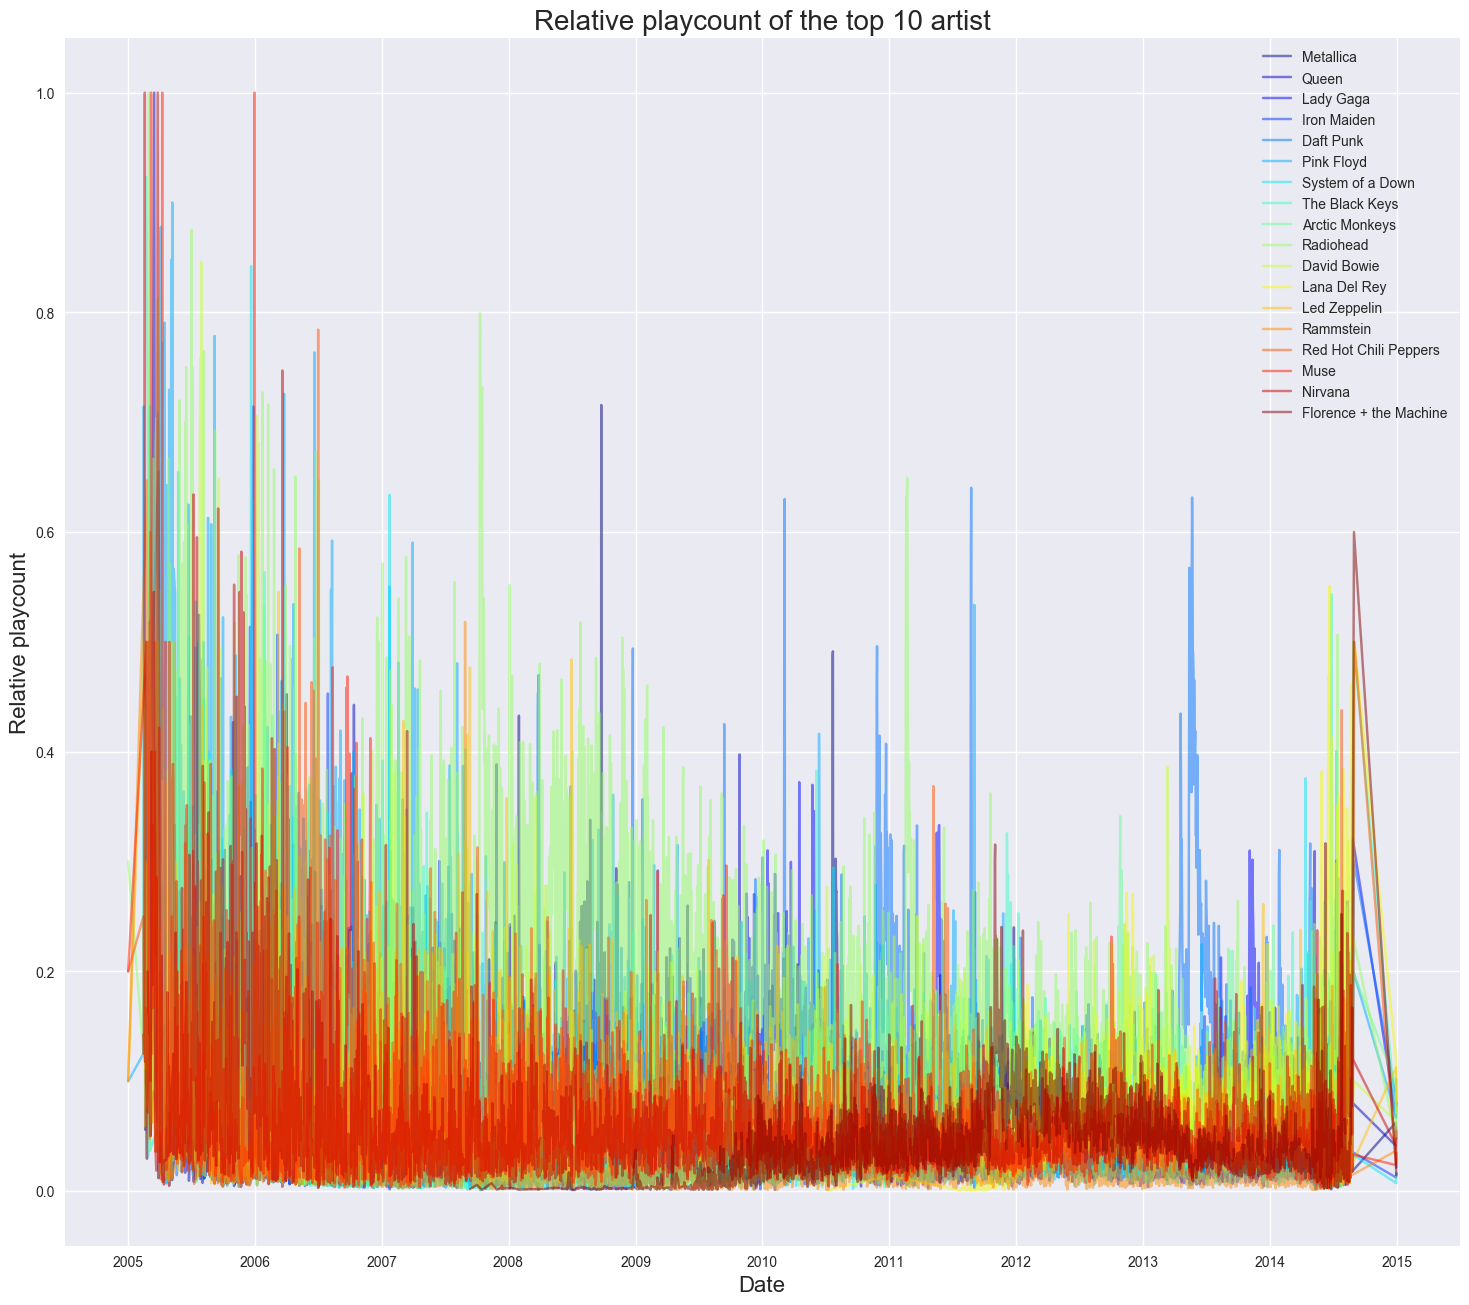

In [5]:
df = pd.DataFrame(json.load(open("../data/data_rel_playcount_artist.json")))
df['date'] = pd.to_datetime(df['week'], format='%Y-%m-%d')
df['relative_play'] = df['relative_play'].astype('float64')
df['playcount'] = df['playcount'].astype('float64')

# FILTER COUNTRIES
DF = df[(df.country == COUNTRY_OF_INTEREST)]
DF.set_index('date', inplace=True)
#print(DF.head())

# PLOT THE RELATIEV PLAYCOUNT OVER TIME FOR EACH ARTIST
fig=plt.figure(figsize=(18, 16), dpi= 100)
cmap = plt.get_cmap('jet')
colors = cmap(np.linspace(0, 1.0, len(set(list(DF['artist'])))))

n=0
for artist in set(list(DF['artist'])):
    DF_temp = DF[(DF.artist == artist)]
    plt.plot(DF_temp.index, DF_temp['relative_play'], label=artist, color=colors[n], alpha=0.5)
    n+=1

plt.title('Relative playcount of the top 10 artist', fontsize = 20)
plt.ylabel('Relative playcount', fontsize = 16)
plt.xlabel('Date', fontsize = 16)
plt.legend()

Furthermore, we load a dataframe that contains the number of unqique listeners per day. This number follows from the listen event file and is used to calculate the number of songs listened per user.


---------------------------------------------------------

Preview of the dataset

        date  number_of_unqiue_listeners
1 2005-02-14                          73
2 2005-02-15                          77
3 2005-02-16                          75
4 2005-02-17                          68
5 2005-02-18                          73

---------------------------------------------------------

Number of days for which we have unique listeners: 3488

---------------------------------------------------------



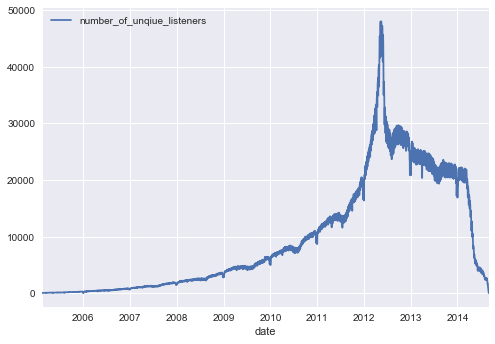

In [6]:
unqiue_listeners_per_day = pd.DataFrame(json.load(open("../data/unique_users_per_day.json")))
unqiue_listeners_per_day['date'] = pd.to_datetime(unqiue_listeners_per_day['date'], format='%Y-%m-%d')
unqiue_listeners_per_day.set_index('date', inplace=True)
unqiue_listeners_per_day.sort_index(inplace=True)
unqiue_listeners_per_day.reset_index(inplace = True)
unqiue_listeners_per_day = unqiue_listeners_per_day[(unqiue_listeners_per_day['date'] > '2005-01-01') & (unqiue_listeners_per_day['date'] < '2014-12-31')]

print('')
print('---------------------------------------------------------')
print('')

print('Preview of the dataset')
print('')
print(unqiue_listeners_per_day.head())

print('')
print('---------------------------------------------------------')
print('')

print('Number of days for which we have unique listeners: %s' % len(list(unqiue_listeners_per_day['number_of_unqiue_listeners'])))

print('')
print('---------------------------------------------------------')
print('')


unqiue_listeners_per_day = unqiue_listeners_per_day[(unqiue_listeners_per_day['date'] > '2005-01-01') & (unqiue_listeners_per_day['date'] < '2014-12-31')]
unqiue_listeners_per_day.plot(x='date', y='number_of_unqiue_listeners')



We perform a regression discontinuity analysis to find any changes in the listening behavior that might be caused by an event. We only consider the three days before and after event. In the regression that considers the absolute playcount we found that including more days causes that effects 

2005


/Users/eelcowiechert/anacona36/anaconda/lib/python3.6/site-packages/ipykernel/__main__.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/eelcowiechert/anacona36/anaconda/lib/python3.6/site-packages/ipykernel/__main__.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/eelcowiechert/anacona36/anaconda/lib/python3.6/site-packages/ipykernel/__main__.py:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the docu


---------------------------------------------------------

R-squared: 0.983145449441

---------------------------------------------------------

Parameters

Intercept                  0.286768
threshold                 -0.263453
days_to_event              0.065783
threshold:days_to_event   -0.039664
dtype: float64

---------------------------------------------------------

P-values

Intercept                  0.006455
threshold                  0.010319
days_to_event              0.025530
threshold:days_to_event    0.120244
dtype: float64

---------------------------------------------------------



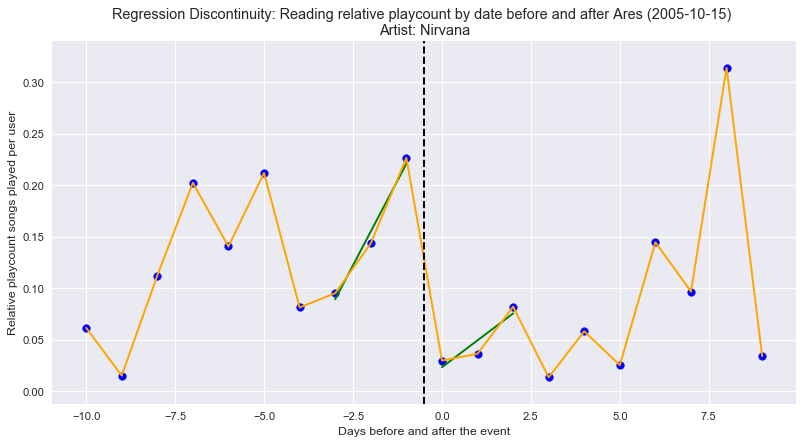

2006
2007
2008

---------------------------------------------------------

R-squared: 0.966640791618

---------------------------------------------------------

Parameters

Intercept                  0.011249
threshold                  0.126549
days_to_event             -0.021797
threshold:days_to_event   -0.037781
dtype: float64

---------------------------------------------------------

P-values

Intercept                  0.612025
threshold                  0.028953
days_to_event              0.130303
threshold:days_to_event    0.092568
dtype: float64

---------------------------------------------------------



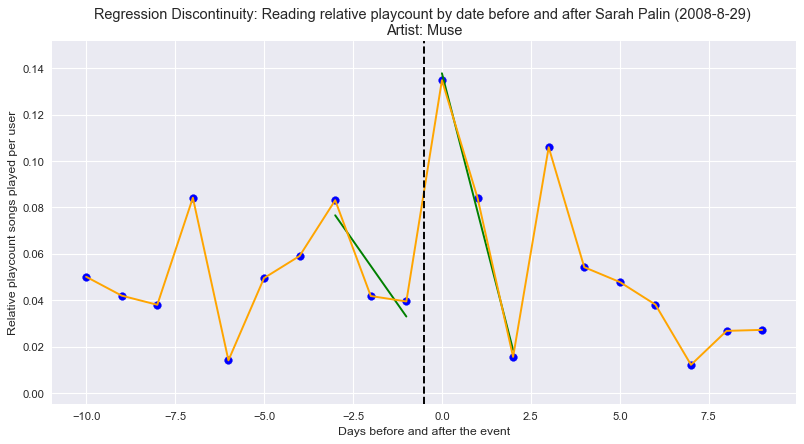

2009

---------------------------------------------------------

R-squared: 0.942268840844

---------------------------------------------------------

Parameters

Intercept                  0.104939
threshold                 -0.094568
days_to_event              0.022789
threshold:days_to_event   -0.007764
dtype: float64

---------------------------------------------------------

P-values

Intercept                  0.020271
threshold                  0.033204
days_to_event              0.083287
threshold:days_to_event    0.516263
dtype: float64

---------------------------------------------------------



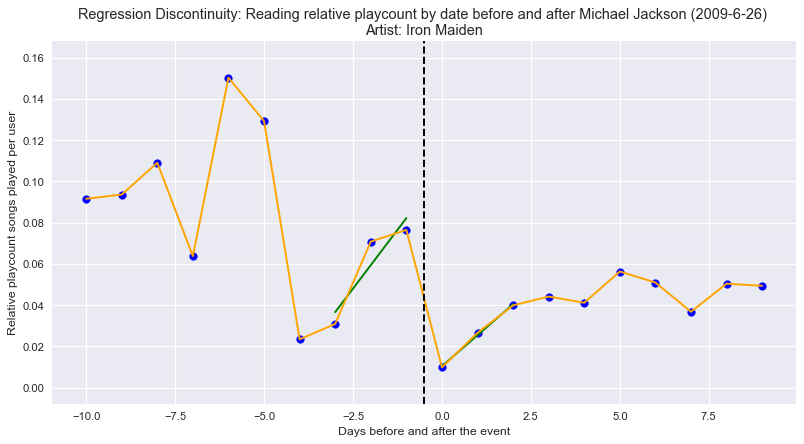

2010

---------------------------------------------------------

R-squared: 0.929405589109

---------------------------------------------------------

Parameters

Intercept                  0.101125
threshold                 -0.081668
days_to_event              0.030914
threshold:days_to_event   -0.036332
dtype: float64

---------------------------------------------------------

P-values

Intercept                  0.024438
threshold                  0.048937
days_to_event              0.053531
threshold:days_to_event    0.074877
dtype: float64

---------------------------------------------------------



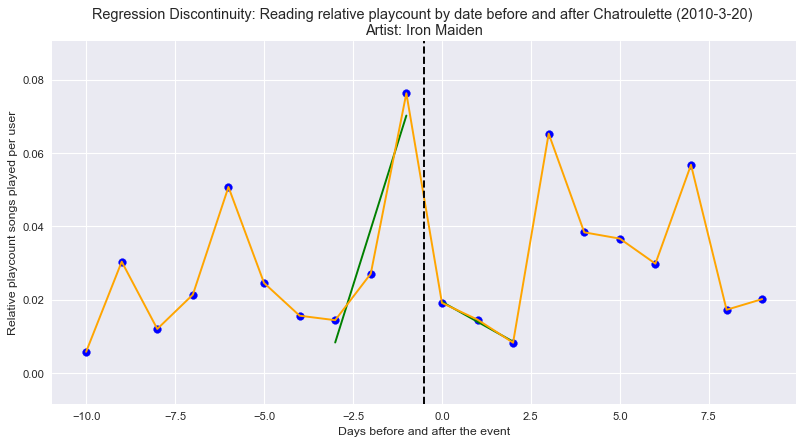

2011

---------------------------------------------------------

R-squared: 0.966963084592

---------------------------------------------------------

Parameters

Intercept                  0.041017
threshold                  0.107438
days_to_event             -0.042857
threshold:days_to_event    0.015382
dtype: float64

---------------------------------------------------------

P-values

Intercept                  0.104840
threshold                  0.023657
days_to_event              0.023481
threshold:days_to_event    0.245288
dtype: float64

---------------------------------------------------------



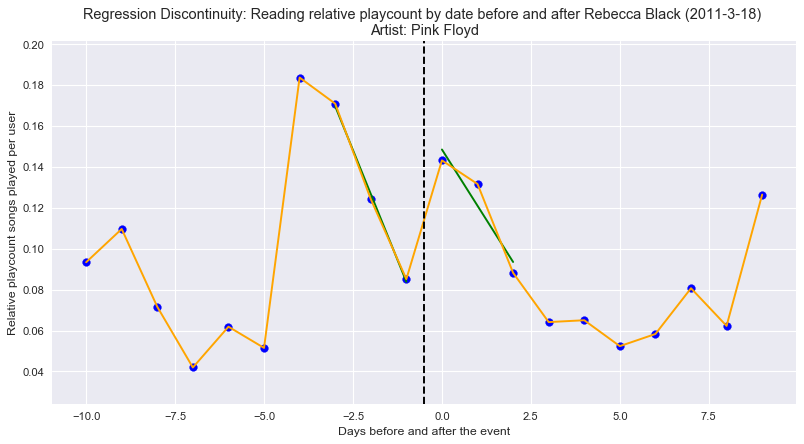


---------------------------------------------------------

R-squared: 0.94252793199

---------------------------------------------------------

Parameters

Intercept                  0.042632
threshold                 -0.033322
days_to_event              0.005123
threshold:days_to_event    0.006156
dtype: float64

---------------------------------------------------------

P-values

Intercept                  0.019593
threshold                  0.042031
days_to_event              0.209186
threshold:days_to_event    0.260732
dtype: float64

---------------------------------------------------------



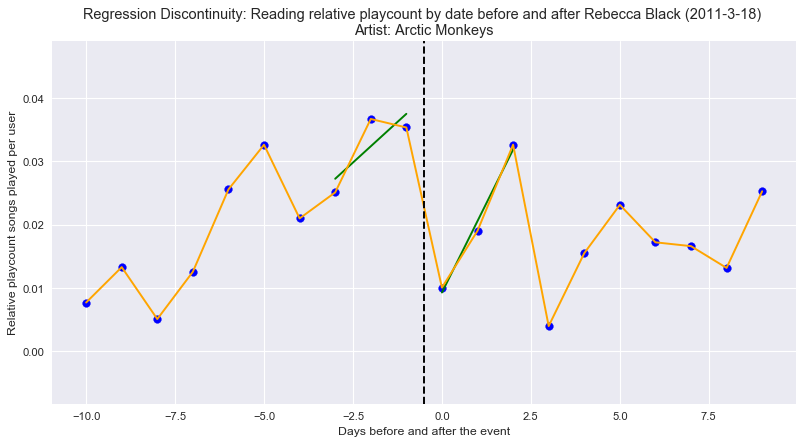

2012
2013

---------------------------------------------------------

R-squared: 0.956436705827

---------------------------------------------------------

Parameters

Intercept                  0.059069
threshold                 -0.041824
days_to_event              0.015284
threshold:days_to_event   -0.015355
dtype: float64

---------------------------------------------------------

P-values

Intercept                  0.009898
threshold                  0.026136
days_to_event              0.030686
threshold:days_to_event    0.058210
dtype: float64

---------------------------------------------------------



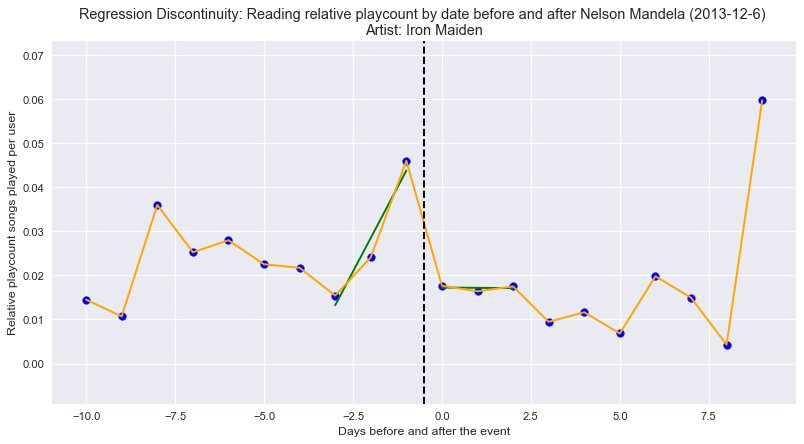


---------------------------------------------------------

R-squared: 0.987384990123

---------------------------------------------------------

Parameters

Intercept                  0.064024
threshold                  0.035903
days_to_event             -0.000146
threshold:days_to_event    0.007468
dtype: float64

---------------------------------------------------------

P-values

Intercept                  0.010284
threshold                  0.042241
days_to_event              0.966034
threshold:days_to_event    0.223372
dtype: float64

---------------------------------------------------------



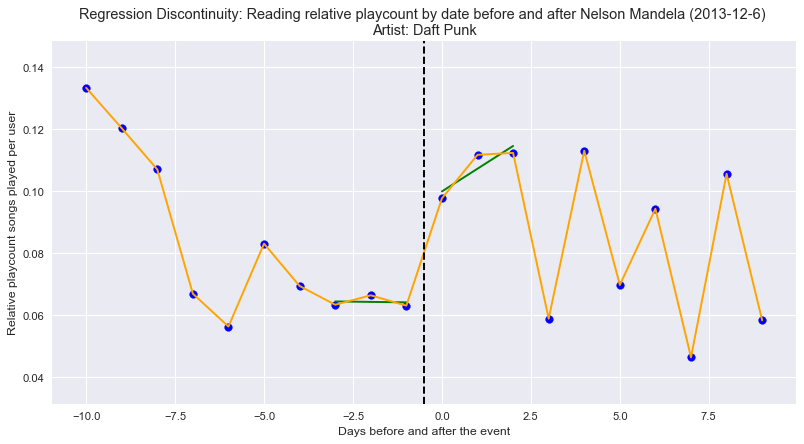


---------------------------------------------------------

R-squared: 0.934897320592

---------------------------------------------------------

Parameters

Intercept                  0.156875
threshold                 -0.078223
days_to_event              0.028524
threshold:days_to_event   -0.028492
dtype: float64

---------------------------------------------------------

P-values

Intercept                  0.007500
threshold                  0.038998
days_to_event              0.045814
threshold:days_to_event    0.086027
dtype: float64

---------------------------------------------------------



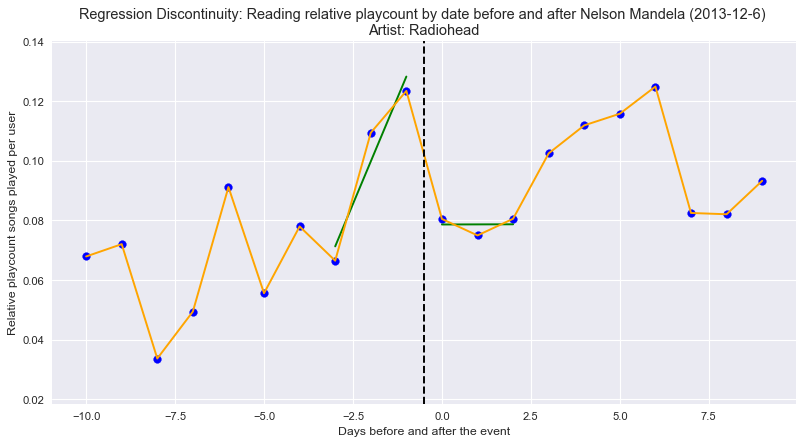

2014

---------------------------------------------------------

R-squared: 0.970517398286

---------------------------------------------------------

Parameters

Intercept                  0.002518
threshold                  0.015585
days_to_event             -0.001689
threshold:days_to_event   -0.003979
dtype: float64

---------------------------------------------------------

P-values

Intercept                  0.367471
threshold                  0.025540
days_to_event              0.236105
threshold:days_to_event    0.108153
dtype: float64

---------------------------------------------------------



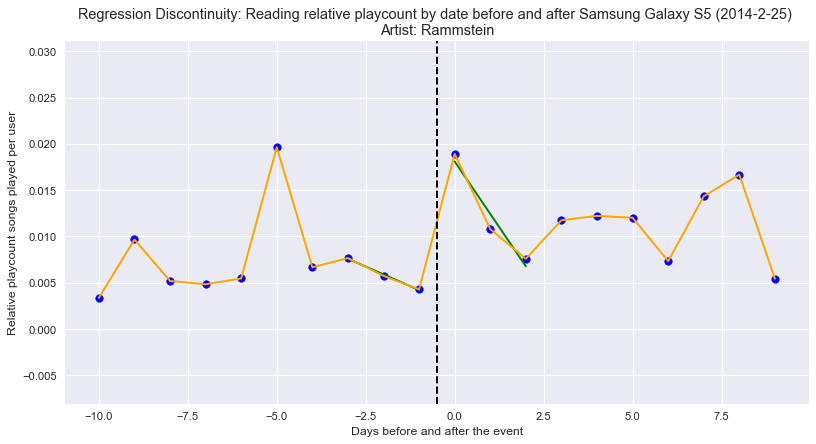


---------------------------------------------------------

R-squared: 0.960676583038

---------------------------------------------------------

Parameters

Intercept                  0.020966
threshold                  0.027965
days_to_event             -0.002738
threshold:days_to_event   -0.005112
dtype: float64

---------------------------------------------------------

P-values

Intercept                  0.046487
threshold                  0.036050
days_to_event              0.334109
threshold:days_to_event    0.237510
dtype: float64

---------------------------------------------------------



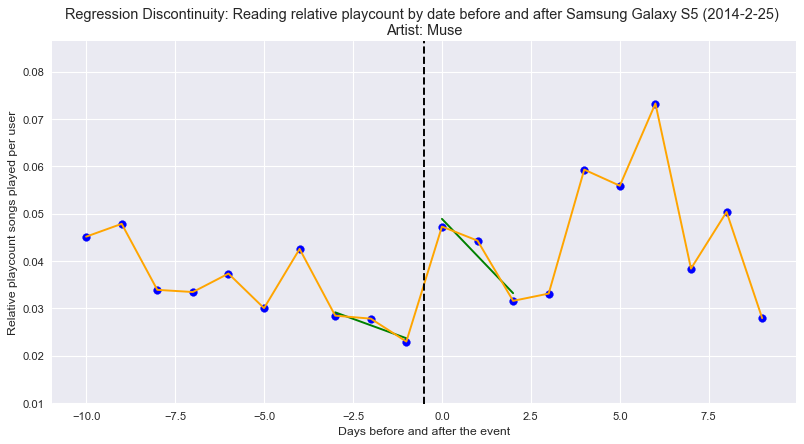

done


In [8]:
N=3

artist_list = list(set(list(DF.artist)))
RDD_results = []

for year in list(set(DF['year'])):
    
    print(year)
    
    for artist in artist_list:
        
        df_focus = DF[((DF.year == year) & (DF.artist == artist))]

        for index, row in events_filtered.iterrows():
            if row.year == year:
                dateEvent = row.date
                dateBefore = row.date - timedelta(days=N)
                dateAfter = row.date + timedelta(days=N)
                interestBefore = row.date - timedelta(days=10)
                interestAfter = row.date + timedelta(days=10)

                def threshold(size):
                    if(size>=dateEvent):
                        return 1
                    return 0

                def days_to_event(size):
                    delta = size - dateEvent
                    return delta.days

                # ONLY FOR X DAYS BEFORE AND AFTER THE EVENT
                data = df_focus[(df_focus.index < dateAfter) & (df_focus.index >= dateBefore)]
                data_interest = df_focus[(df_focus.index < interestAfter) & (df_focus.index >= interestBefore)]

                # WHEN THE FILTERING RETURNS AN EMPTY DATAFRAME => CONTINUE
                if data.empty or len(list(data.relative_play)) < 5:
                    continue

                data['threshold'] = data.index.map(threshold)
                data['days_to_event'] = data.index.map(days_to_event)

                data_interest['days_to_event'] = data_interest.index.map(days_to_event)
                
                result = sm.ols(formula="relative_play ~ threshold + days_to_event + threshold * days_to_event", data=data).fit()
                
                r = [str(row.description), str(row.category), artist, str(row.year) + '-'+ str(row.month) + '-'+ str(row.day), result.rsquared, result.params.Intercept, result.params.days_to_event, result.params.threshold, result.params[3], result.pvalues.Intercept, result.pvalues.days_to_event, result.pvalues.threshold, result.pvalues[3]]
                #print(r)
                RDD_results.append(r)
                
                # If sinificant, plot lines
                if result.pvalues['threshold'] <0.05:

                    #print(result.summary())
                    print('')
                    print('---------------------------------------------------------')
                    print('')

                    print('R-squared: %s' % result.rsquared)

                    print('')
                    print('---------------------------------------------------------')
                    print('')
                    print('Parameters')
                    print('')
                    print(result.params)
                    print('')
                    print('---------------------------------------------------------')
                    print('')
                    print('P-values')
                    print('')
                    print(result.pvalues)
                    print('')
                    print('---------------------------------------------------------')
                    print('')

                    plt.figure(num=None, figsize=(12, 6), dpi=80, facecolor='w', edgecolor='k')
                    plt.scatter(data_interest.days_to_event,data_interest.relative_play, color="blue")
                    plt.plot(data.days_to_event[:3], result.predict()[:3], '-', color='green')
                    plt.plot(data.days_to_event[3:], result.predict()[3:], '-', color='green')
                    plt.plot(data_interest.days_to_event, data_interest.relative_play, '-', color='orange')
                    plt.axvline(x=-0.5,color="black", linestyle="--")
                    plt.xlabel('Days before and after the event')
                    plt.ylabel('Relative playcount songs played per user')
                    plt.title("Regression Discontinuity: Reading relative playcount by date before and after " + str(row.description) + " (" + str(row.year) + '-'+ str(row.month) + '-'+ str(row.day) +") \n" + 'Artist: ' + str(artist) , fontsize="13")
                    #plt.savefig('../data/figures/RDD_' + str(row.description) + '_' + str(row.year) + '-'+ str(row.month) + '-'+ str(row.day) + '.png', dpi=300)
                    #plt.close()
                    plt.show()
                break
                
print('done')


From the plots above we can see that discontinuities occur for some events, however it is very hard to assign these to the event itself as overall there are heavy fluctuations in the data.

In [9]:
RDD_results = pd.DataFrame(RDD_results, columns=['description', 'category', 'artist', 'date', 'r2', 'params.Intercept', 'params.days_to_event', 'params.threshold', 'params.threshold*days_to_event', 'pvalues.Intercept', 'pvalues.days_to_event', 'pvalues.threshold', 'pvalues.threshold*days_to_event'])
print(RDD_results.head())
RDD_results['date'] = pd.to_datetime(RDD_results['date'], format='%Y-%m-%d')

RDD_results.to_csv('../data/RDD_3days_linear_threshold.csv', sep='\t', encoding='utf-8')

  description  category       artist        date        r2  params.Intercept  \
0        Ares  trending    Metallica  2005-10-15  0.939622          0.102692   
1        Ares  trending        Queen  2005-10-15  0.999736          0.047004   
2   Wikipedia  trending  Iron Maiden  2005-12-11  0.996074          0.454468   
3        Ares  trending    Daft Punk  2005-10-15  0.946376          0.015668   
4        Ares  trending   Pink Floyd  2005-10-15  0.953167          0.230146   

   params.days_to_event  params.threshold  params.threshold*days_to_event  \
0              0.027526          0.061488                       -0.037160   
1              0.016076          0.012923                       -0.031002   
2              0.150226         -0.068754                       -0.172304   
3              0.005359         -0.001444                       -0.009090   
4              0.031559         -0.367324                        0.160164   

   pvalues.Intercept  pvalues.days_to_event  pvalues.thr

In [10]:
RDD_result_filter = RDD_results[((RDD_results['date'].dt.year == 2009) & (RDD_results['pvalues.threshold'] <0.05))]

print(RDD_result_filter.head())

        description category       artist       date        r2  \
47  Michael Jackson  popular  Iron Maiden 2009-06-26  0.942269   

    params.Intercept  params.days_to_event  params.threshold  \
47          0.104939              0.022789         -0.094568   

    params.threshold*days_to_event  pvalues.Intercept  pvalues.days_to_event  \
47                       -0.007764           0.020271               0.083287   

    pvalues.threshold  pvalues.threshold*days_to_event  
47           0.033204                         0.516263  
